### Load Libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

### Load Data

In [6]:
df = pd.read_csv('../data/train.csv',index_col=0, parse_dates=True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


In [7]:
# check missing values
df.isna().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

### Data Preprocessing

#### Extract time features

In [13]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,weekday,hour
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,5,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,5,4


### Exploratory Data Analysis

#### Analyze average of counts per time 

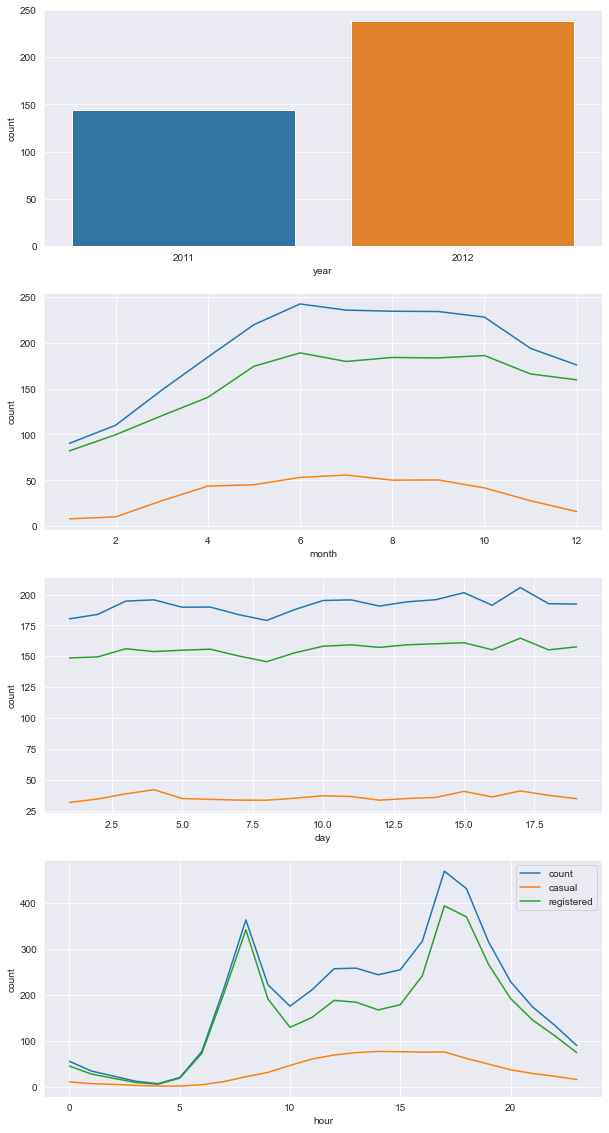

In [34]:
fig, ax = plt.subplots(4, 1, figsize=(10, 20))
ax = ax.flatten() 
features = ['year','month','day','hour']
for index,feature in enumerate(features):
    #sns.barplot(ax=ax[index],x=features[index],y='count',data=df.groupby(features[index])['count'].mean().reset_index())

    if feature == 'year':
        sns.barplot(ax=ax[index],x=features[index],y='count',data=df.groupby(features[index])['count'].mean().reset_index())
    else:
        sns.lineplot(ax=ax[index],x=features[index],y='count',data=df.groupby(features[index])['count'].mean().reset_index())
        sns.lineplot(ax=ax[index],x=features[index],y='casual',data=df.groupby(features[index])['casual'].mean().reset_index())
        sns.lineplot(ax=ax[index],x=features[index],y='registered',data=df.groupby(features[index])['registered'].mean().reset_index())
    ax[i].legend(['count','casual','registered'])


